In [1]:
class User:
    def __init__(self, user_id, name, age, gender,gender_preference, min_age_preference, max_age_preference, location, interests, password, drinks, smoke, job, Pets, Language, Location_Preference,
                 liked_users=None, disliked_users=None, matches=None):
        self.user_id = user_id
        self.name = name
        self.age = age
        self.gender = gender
        self.gender_preference = gender_preference
        self.min_age_preference = min_age_preference
        self.max_age_preference = max_age_preference
        self.location = location
        self.drinks = drinks
        self.smoke = smoke
        self.job = job
        self.pets = Pets
        self.languages = Language
        self.Location_Preference = Location_Preference
        self.interests = interests
        self.password = password
        self.liked_users = liked_users if liked_users is not None else []
        self.disliked_users = disliked_users if disliked_users is not None else []
        self.matches = matches if matches is not None else []

    def __repr__(self):
        return (f'User({self.user_id}, {self.name}, {self.age}, {self.gender}, '
                f'{self.location}, {self.interests}, {self.liked_users}, '
                f'{self.disliked_users}, {self.matches})')


In [2]:
import sqlite3
import os
import pandas as pd


class DatabaseManager:
    def __init__(self, db_file='tinder.db'):
        self.db_file = db_file

    def connect(self):
        self.conn = sqlite3.connect(self.db_file)
        self.cursor = self.conn.cursor()

    def close(self):
        self.conn.close()

    def reset_database(self):
        # Remove the existing database file if it exists
        if os.path.exists(self.db_file):
            os.remove(self.db_file)
            print(f"Deleted existing database file: {self.db_file}")
        self.setup_database()
        
    def setup_database(self):
        self.connect()
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS users (
                user_id INTEGER PRIMARY KEY,
                name TEXT,
                age INTEGER,
                gender TEXT,
                gender_preference TEXT,
                min_age_preference INTEGER,
                max_age_preference INTEGER,
                location TEXT,
                drinks TEXT,
                smoke TEXT,
                job TEXT,
                Pets TEXT,
                Languages TEXT,
                Location_Preference TEXT,
                interests TEXT,
                liked_users TEXT,
                disliked_users TEXT,
                matches TEXT,
                password TEXT  -- New column for password
            )
        ''')
        self.conn.commit()
        self.close()


    def insert_user(self, user_data):
        try:
            self.connect()
            self.cursor.execute('''
                INSERT INTO users (
                    user_id, name, age, gender, gender_preference, min_age_preference, max_age_preference, 
                    location, drinks, smoke, job, Pets, Languages, Location_Preference, interests, 
                    liked_users, disliked_users, matches, password
                ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                user_data['user_id'], user_data['name'], user_data['age'], user_data['gender'],
                user_data['Gender Preference'], user_data['Min Age Preference'], user_data['Max Age Preference'],
                user_data['location'], user_data['drinks'], user_data['smoke'], user_data['job'],
                user_data['Pets'], user_data['Languages'], user_data['Location_Preference'], 
                user_data['interests'], user_data['liked_users'], user_data['disliked_users'],
                user_data['matches'], user_data['password']
            ))
            self.conn.commit()
        except Exception as e:
            print(f"Error inserting user: {e}")
        finally:
            self.close()





    def fetch_user(self, user_id):
        """Fetches a user by their user ID from the database."""
        self.connect()
        cursor = self.conn.cursor()
        cursor.execute("SELECT * FROM users WHERE user_id = ?", (user_id,))
        user_data = cursor.fetchone()
        self.close()
        
        
        if user_data:
            # Create a User object with the retrieved data
            user = User(
                user_id=user_data[0],
                name=user_data[1],
                age=user_data[2],
                gender=user_data[3],
                gender_preference=user_data[4],
                min_age_preference=user_data[5],
                max_age_preference=user_data[6],
                location=user_data[7],
                drinks=user_data[8],
                smoke=user_data[9],
                job=user_data[10],
                Pets=user_data[11],
                Language=user_data[12],
                Location_Preference=user_data[13],
                interests=user_data[14],
                liked_users=user_data[15].split(',') if user_data[15] else [],
                disliked_users=user_data[16].split(',') if user_data[16] else [],
                matches=user_data[17].split(',') if user_data[17] else [],
                password=user_data[18]
            )
            return user
        
        return None

    def delete_user(self, user_id):
        self.connect()
        
        # Fetch only the necessary columns
        self.cursor.execute('SELECT user_id, liked_users, disliked_users, matches FROM users')
        all_users = self.cursor.fetchall()
        
        for user_data in all_users:
            current_user_id, liked_users, disliked_users, matches = user_data
            
            # Convert liked_users, disliked_users, and matches to lists
            liked_users_list = list(map(int, liked_users.split(','))) if liked_users else []
            disliked_users_list = list(map(int, disliked_users.split(','))) if disliked_users else []
            matches_list = list(map(int, matches.split(','))) if matches else []
            
            # Remove the user_id from these lists if it exists
            if user_id in liked_users_list:
                liked_users_list.remove(user_id)
            if user_id in disliked_users_list:
                disliked_users_list.remove(user_id)
            if user_id in matches_list:
                matches_list.remove(user_id)
            
            # Convert lists back to strings
            liked_users = ','.join(map(str, liked_users_list))
            disliked_users = ','.join(map(str, disliked_users_list))
            matches = ','.join(map(str, matches_list))
            
            # Update the current user's liked, disliked, and matches lists
            self.cursor.execute('''
                UPDATE users
                SET liked_users = ?, disliked_users = ?, matches = ?
                WHERE user_id = ?
            ''', (liked_users, disliked_users, matches, current_user_id))
        
        # Delete the user from the users table
        self.cursor.execute('DELETE FROM users WHERE user_id = ?', (user_id,))
        
        # Commit the changes to the database
        self.conn.commit()
        
        # Close the database connection
        self.close()


    def statsbyloc(self,location):
        conn = sqlite3.connect('tinder.db')
        df = pd.read_sql_query("SELECT * FROM users", conn)
        conn.close()

        tinder_df = fetch_all_users()
        #tinder_df.head()
        df = tinder_df[tinder_df['location'] == location]
        print("People in your area by age")
        df
            # Set the size of the figure to 10 inches
        # wide by 8 inches tall
        plt.figure(figsize=(6, 6))

        # Divide the data into categories
        bins = [18, 21, 23, 25, 27, 29]

        # Use the `cut` function to assign
        # each data point to a category
        categories = pd.cut(df["age"], bins,
                  labels=["18-20", "21-23", "23-25",
                      "25-27", "27-29"])


        # Count the number of data points in each category
        counts = categories.value_counts()

        # Plot the data as a pie chart
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
        plt.show()

    def statsbyjob(self,job):
        conn = sqlite3.connect('tinder.db')
        df = pd.read_sql_query("SELECT * FROM users", conn)
        conn.close()

        tinder_df = fetch_all_users()
        df = tinder_df[tinder_df['job'] == job]
        print("People in your area with the same job")
        df
        plt.figure(figsize=(6, 6))
        sns.histplot(x="job", data=df,
              color="coral")

        # rotate x-axis labels vertically
        plt.xticks(rotation=90)
        plt.title("Distribution of job of each candidate",
            fontsize=14)

        plt.xlabel("Job name", fontsize=12)
        plt.ylabel("Count of people", fontsize=12)

        plt.show()


    def insert_many_users(self, users):
        self.connect()
        self.cursor.executemany('''
            INSERT INTO users (name, age, gender,gender_preference, min_age_preference, max_age_preference, 
                                location, drinks, smoke, job, Pets, Languages, Location_Preference, interests, liked_users, disliked_users, matches, password)
            VALUES (:name, :age, :gender, :gender_preference, :min_age_preference,:max_age_preference
                                , :location, :drinks, :smoke, :job, :Pets, :Languages, :Location_Preference, :interests, 
                                :liked_users, :disliked_users, :matches, :password)
        ''', users)
        self.conn.commit()
        self.close()



    def get_max_user_id(self):
        self.connect()
        self.cursor.execute('SELECT MAX(user_id) FROM users')
        max_id = self.cursor.fetchone()[0]
        self.close()
        return max_id if max_id else 0  # Return 0 if no users exist
    

    def update_user_info(self, user_id, updated_data):
        """
        Updates specific user information for a given user_id.
        :param user_id: ID of the user to update.
        :param updated_data: Dictionary containing updated user data.
        """
        try:
            self.connect()

            # Dynamically construct the SET clause from the updated_data keys
            set_clause = ', '.join([f"{key} = :{key}" for key in updated_data.keys()])

            query = f'''
                UPDATE users
                SET {set_clause}
                WHERE user_id = :user_id
            '''

            print(f"Executing query: {query}")
            print(f"With data: {updated_data}, user_id: {user_id}")

            # Add user_id to the dictionary
            updated_data['user_id'] = user_id

            self.cursor.execute(query, updated_data)
            self.conn.commit()
            print("Database update successful.")
        except Exception as e:
            print(f"Error updating user in database: {e}")
        finally:
            self.close()

    def get_liked_users(self, user_id):
        query = "SELECT liked_users FROM users WHERE user_id = ?"
        self.cursor.execute(query, (user_id,))
        result = self.cursor.fetchone()

        if result:
            liked_users_str = result[0]
            if liked_users_str:
                liked_users = list(map(int, liked_users_str.split(',')))
                return liked_users
        return []



In [3]:
import random
import names

# Random data generation
random_names = [names.get_full_name() for _ in range(5000)]
gender_list = ["Male", "Female", "Others"]
gender_pref = ["Male", "Female", "Others"]
locations = [
    "New York", "Los Angeles", "Chicago", "Philadelphia", "San Antonio", "San Diego", "Ottawa", "Montreal", "Quebec City",
    "Charlotte", "San Francisco", "Seattle", "Washington", "Boston", "Toronto", "Detroit", "Waterloo", "Halifax",
    "Las Vegas", "Kingston", "Vancouver", "Calgary"]
interests = ["Reading", "Traveling", "Cooking", "Hiking", "Photography", "Music", "Gaming", "Sports",
             "Art", "Yoga", "Dancing", "Movies", "Cycling", "Gardening", "Writing", "Fishing", "Fitness", "Volunteering", "Crafting", "Meditation"]

drink = ["Socially", "Rarely", "Often", "Very Often", "No"]
smokes = ["Socially", "Rarely", "Often", "Very Often", "No"]
Jobs = ["Software Engineer", "Doctor", "Teacher", "Nurse", "Project Manager", "Accountant",
        "Marketing Manager", "Data Scientist", "Lawyer", "Sales Executive", "Graphic Designer", "Human Resources Manager"]
Pets = ["Dog", "Cat", "No", "Others"]
Languages = ["English", "French"]
Location_Preference = ["Same City", "Anything Works"]

def generate_and_insert_users():
    insert1 = DatabaseManager()
    # Reset the database
    insert1.reset_database()
    insert1.setup_database()  # Ensure the database and table are set up
    insert1.connect()  # Connect to the database before inserting users
    users = []

    # Dictionary to store matches and ensure reciprocal matching
    reciprocal_matches = {}
    reciprocal_likes = {}

    for i in range(5000):
        name = random_names[i]
        age = random.randint(18, 60)
        gender = random.choice(gender_list)
        gender_preference = random.choice(gender_pref)
        min_age_preference = random.randint(18, 64)
        max_age_preference = random.randint(min_age_preference+1, 65)
        location = random.choice(locations)
        drinks = random.choice(drink)
        smoke = random.choice(smokes)
        job = random.choice(Jobs)
        pets = random.choice(Pets)
        languages = random.choice(Languages)
        location_preference = random.choice(Location_Preference)

        # Fix the usage of random.sample
        user_interests = ', '.join(random.sample(interests, random.randint(3, 8)))

        user_id = i + 1  # Assuming user_id starts from 1

        # Generate matches and ensure they are reciprocal
        matches = []
        liked_users = []
        if user_id in reciprocal_matches:
            matches = reciprocal_matches[user_id]
            liked_users = reciprocal_likes[user_id]
        else:
            potential_matches = sorted(set(range(1, 5001)) - {user_id})
            matches = random.sample(potential_matches, random.randint(0, 2))
            liked_users = matches.copy()  # Same users will be liked as well

            for match_id in matches:
                if match_id not in reciprocal_matches:
                    reciprocal_matches[match_id] = []
                    reciprocal_likes[match_id] = []
                reciprocal_matches[match_id].append(user_id)
                reciprocal_likes[match_id].append(user_id)

        # Add 0-2 additional liked users
        additional_liked_users = random.sample(
            sorted(set(range(1, 5001)) - {user_id} - set(liked_users) - set(matches)),
            random.randint(2, 5)
        )
        liked_users.extend(additional_liked_users)

        matched_str = ','.join(map(str, matches))
        liked_users_str = ','.join(map(str, liked_users))
        disliked_users = random.sample(
            sorted(set(range(1, 5001)) - {user_id} - set(liked_users)),
            random.randint(0, 3)
        )
        disliked_users_str = ','.join(map(str, disliked_users))

        # Set the password as "user{user_id}"
        password = f"user{user_id}"

        userdict = {
            "name": name,
            "age": age,
            "gender": gender,
            "gender_preference": gender_preference,
            "min_age_preference": min_age_preference,
            "max_age_preference": max_age_preference,
            "location": location,
            "drinks": drinks,
            "smoke": smoke,
            "job": job,
            "Pets": pets,
            "Languages": languages,
            "Location_Preference": location_preference,
            "interests": user_interests,
            "password": password,
            "liked_users": liked_users_str,
            "disliked_users": disliked_users_str,
            "matches": matched_str
        }

        users.append(userdict)

    insert1.insert_many_users(users)  # Insert all users while the connection is open
    insert1.close()  # Close the connection after all users are inserted
    print("5000 users have been inserted into the database.")
    return users

# Call the function to generate and insert users
newuser = generate_and_insert_users()


Deleted existing database file: tinder.db
5000 users have been inserted into the database.


In [4]:
insert1 = DatabaseManager()

# Load All Users into a Pandas DataFrame
def fetch_all_users():
    conn = sqlite3.connect('tinder.db')
    df = pd.read_sql_query("SELECT * FROM users", conn)
    conn.close()
    return df

tinder_df = fetch_all_users()
tinder_df.head()

test_df = fetch_all_users()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid",
			{"grid.color": ".6",
			"grid.linestyle": ":"})
#import category_encoders as ce
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
def statsbyloc(location):
    df = tinder_df[tinder_df['location'] == location]
    print("People in your area by age")
    df
        # Set the size of the figure to 10 inches
    # wide by 8 inches tall
    plt.figure(figsize=(6, 6))

    # Divide the data into categories
    bins = [18, 21, 23, 25, 27, 29]

    # Use the `cut` function to assign
    # each data point to a category
    categories = pd.cut(df["age"], bins,
              labels=["18-20", "21-23", "23-25",
                  "25-27", "27-29"])


    # Count the number of data points in each category
    counts = categories.value_counts()

    # Plot the data as a pie chart
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.show()

def statsbyjob(job):
    df = tinder_df[tinder_df['job'] == job]
    print("People in your area with the same job")
    df
    plt.figure(figsize=(6, 6))
    sns.histplot(x="job", data=df,
          color="coral")

    # rotate x-axis labels vertically
    plt.xticks(rotation=90)
    plt.title("Distribution of job of each candidate",
        fontsize=14)

    plt.xlabel("Job name", fontsize=12)
    plt.ylabel("Count of people", fontsize=12)

    plt.show()



People in your area by age


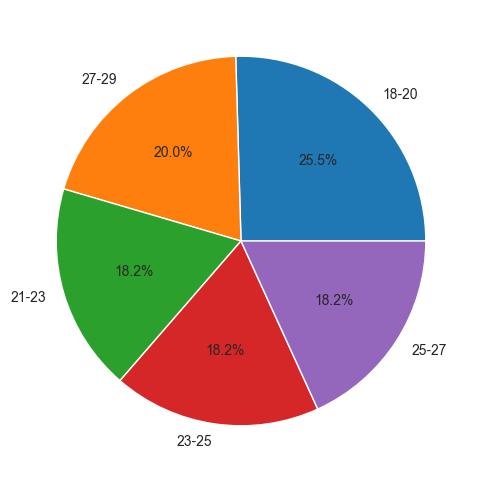

People in your area with the same job


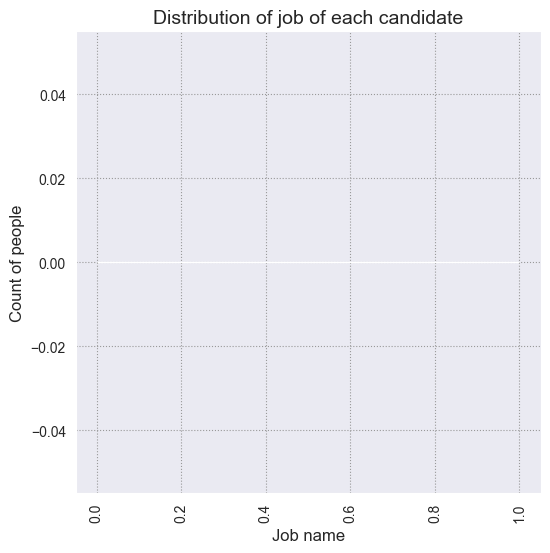

In [7]:
statsbyloc("Toronto")
statsbyjob("Student")
#

In [8]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

def encoding(tinder_df):
	drinking_habit = {
		'Socially': 'sometimes',
		'Rarely': 'sometimes',
		'No': 'do not drink',
		'Often': 'drinks often',
		'VeryOften': 'drinks often',
		'Very Often': 'drinks often',
		'Desperately': 'drinks often'

	}
	tinder_df['drinks'] = tinder_df['drinks'].apply(lambda x:drinking_habit[x])
	# create a LabelEncoder object
	habit_encoder = LabelEncoder()

	# fit the encoder on the drinks and drugs columns
	habit_encoder.fit(tinder_df[['drinks', 'smoke']]
					.values.reshape(-1))

	# encode the drinks and drugs columns
	# using the fitted encoder
	tinder_df['drinks_encoded'] = habit_encoder.transform(tinder_df['drinks'])
	tinder_df['smoke_encoded'] =  habit_encoder.transform(tinder_df['smoke'])

	# Drop the existing drink and drugs column
	tinder_df.drop(["drinks", "smoke"], axis=1,
				inplace=True)
	
	bin_enc = ce.BinaryEncoder(cols=['Pets'])

	# fit and transform the pet column
	pet_enc = bin_enc.fit_transform(tinder_df['Pets'])

	# add the encoded columns to the original dataframe
	tinder_df = pd.concat([tinder_df, pet_enc], axis=1)

	tinder_df.drop("Pets",axis=1,inplace = True)	# create a LabelEncoder object
	
	place_type_strength = {
	'Anything Works': 1.0,
	'Same City': 2.0
	}
	tinder_df['loc_pref'] = tinder_df['Location_Preference']
	tinder_df['Location_Preference'] = tinder_df['Location_Preference'].apply(lambda x: place_type_strength[x])


	unique_values_column = {
		'gender': {'female': 1, 'male': 0},

	}

	tinder_df.replace(unique_values_column,
					inplace=True)
	


	job_encoder = LabelEncoder()

	# fit the encoder on the job column
	job_encoder.fit(tinder_df['job'])

	# encode the job column using the fitted encoder
	tinder_df['job_encoded'] = job_encoder.transform(tinder_df['job'])

	# drop the original job column
	tinder_df.drop('job', axis=1, inplace=True)
	# create a LabelEncoder object
	# perform one hot encoding
	location_encoder = OneHotEncoder()

	# fit and transform the location column
	location_encoded = location_encoder.fit_transform(tinder_df[['location']])

	# create a new DataFrame with the encoded columns
	location_encoded_df = pd.DataFrame(location_encoded.toarray(), columns=location_encoder.get_feature_names_out(['location']))

	# concatenate the new DataFrame with the original DataFrame
	tinder_df = pd.concat([tinder_df, location_encoded_df], axis=1)
	# Drop the existing location column
	#tinder_df.drop(["location"], axis=1, inplace=True)
	# concatenate the new DataFrame with the original DataFrame
	#tinder_df = pd.concat([tinder_df, location_encoded_df], axis=1)
	#print (tinder_df)
	# Drop the existing location column
	#tinder_df.drop(["location"], axis=1, inplace=True)
	return tinder_df

In [9]:

def recommend(user_df, num_recommendations=5000):
    insert1 = DatabaseManager()
    
    # Fetch and process all users
    test_df = pd.DataFrame(fetch_all_users())
    tinder_df = encoding(test_df)

    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(tinder_df['interests'])

    # Convert TF-IDF matrix to DataFrame
    feature_names = tfidf.vocabulary_
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    # Transform new user's interests
    new_user_interests = user_df['interests'].iloc[0]  # Single string expected
    if isinstance(new_user_interests, list):
        new_user_interests = ' '.join(new_user_interests)  # Join list into a single string
    new_user_tfidf = tfidf.transform([new_user_interests])  # Wrap the single string in a list
    new_user_tfidf_df = pd.DataFrame(new_user_tfidf.toarray(), columns=feature_names)

    # Prepare user_df for concatenation
    user_df = user_df.drop(["interests"], axis=1)

    # Ensure user_df has the same columns as tinder_dfs
    
    user_df = pd.concat([user_df, new_user_tfidf_df], axis=1)
    user_df = user_df.fillna(0)  # Ensure no NaN values

        # Add non-text features to the tfidf_df dataframe
    tinder_dfs = tinder_df.drop(["interests","gender","gender_preference","min_age_preference","max_age_preference","location","loc_pref","name","Location_Preference","liked_users","disliked_users","matches","Languages","password"], axis=1)
    tinder_dfs = pd.concat([tinder_dfs,
                            tfidf_df], axis=1)


    tinder_dfs = tinder_dfs.fillna(0)
    # Apply SVD to the feature matrix
    svd = TruncatedSVD(n_components=min(2, 100))
    svd_matrix = svd.fit_transform(tinder_dfs)

    # Calculate the cosine similarity
    # between all pairs of users
    cosine_sim = cosine_similarity(svd_matrix)

    # --- Changes start here ---
    # Ensure user_df has the same columns as tinder_dfs before filling missing values
    user_df = user_df.reindex(columns=tinder_dfs.columns, fill_value=0)

    # Get the number of features in the training data
    n_features_train = svd_matrix.shape[1]

    user_df_array = user_df.values
    #print(user_df_array)
    # --- Changes end here ---

    missing_features = n_features_train - user_df_array.shape[1] # Use n_features_train here
    if missing_features > 0:
        user_df_array = np.hstack((user_df_array, np.zeros((user_df_array.shape[0], missing_features))))
    

    # Reshape the array to match the expected input shape for SVD
    user_df_array = user_df_array.reshape(1, -1)
   # print("user_df after hstack",user_df_array)

    # Apply SVD to the feature matrix
    svd_matrixs = svd.transform(user_df_array)
    #print("svd_matrixs after transform", svd_matrixs)

    # Calculate the cosine similarity
    # between the user_df and training set users
    cosine_sim_new = cosine_similarity(svd_matrixs, svd_matrix)

    # Get the indices of the top
    # num_recommendations similar users
    sim_scores = list(enumerate(cosine_sim_new[0]))
    sim_scores = sorted(sim_scores,
                        key=lambda x: x[1], reverse=True)
    # Filter sim_indices to be within the bounds of the filtered tinder_df
    sim_indices = [i[0] for i in sim_scores[1:num_recommendations+1] if i[0] < len(tinder_df)] 
    recommended_df = tinder_df.iloc[sim_indices]
    recommended_df['score'] = [cosine_sim_new[0][i] for i in sim_indices]
    print("tinder_df after adding score", recommended_df)
    #print("sim_indices", sim_scores)
    # Return the user_ids of the recommended users
    return recommended_df

In [10]:
import tkinter as tk
from tkinter import messagebox
from PIL import Image, ImageTk
import pandas as pd
import requests
from PIL import Image
from io import BytesIO




class MatchmindApp:
    def __init__(self, root):
        self.root = root
        self.db_manager = DatabaseManager()
        self.db_manager.setup_database()
        self.current_user = None
        self.remaining_recommended_users = []  # Initialize the list to store remaining recommended users


        # Define necessary lists for dropdowns and checkboxes
        self.genders = ["Male", "Female", "Others"]
        self.gender_preference = ["Male", "Female", "Others"]
        self.locations = [
            "New York", "Los Angeles", "Chicago", "Philadelphia", "San Antonio", "San Diego", "Ottawa", "Montreal", 
            "Quebec City", "Charlotte", "San Francisco", "Seattle", "Washington", "Boston", "Toronto", "Detroit", 
            "Waterloo", "Halifax", "Las Vegas", "Kingston", "Vancouver", "Calgary"
        ]
        self.interests = ["Reading", "Traveling", "Cooking", "Hiking", "Photography", "Music", 
                          "Gaming", "Sports", "Art", "Yoga", "Dancing", "Movies", "Cycling", "Gardening", 
                          "Writing", "Fishing", "Fitness", "Volunteering", "Crafting", "Meditation"]

        self.drink = ["Socially", "Rarely", "Often", "Very Often", "No"]
        self.smokes = ["Socially", "Rarely", "Often", "Very Often", "No"]
        self.Jobs = ["Software Engineer", "Doctor","Teacher", "Nurse","Project Manager", "Accountant","Marketing Manager","Data Scientist", "Lawyer", "Sales Executive", "Graphic Designer","Human Resources Manager"]
        self.Pets = ["Dog", "Cat", "No", "Others"]
        self.language = ["English", "French"]
        self.Location_Preference = ["Same City", "Anything Works"]

        self.user_id_input = None  # Placeholder for the current user ID
        self.submit_clicked = False  # Track if submit button has been clicked
        self.setup_login_page()

        # Mock matched users as a Pandas DataFrame
        self.mock_matched_users_df = test_df.iloc[0:5]

    def setup_login_page(self):
        self.clear_window()
        self.root.title("Welcome to Matchmind!")
        self.root.geometry("650x500")

        # Create the left frame for the background image
        left_frame = tk.Frame(self.root, bg="#ffffff")
        left_frame.place(relx=0, rely=0, relwidth=0.4, relheight=1)  # Occupies 40% of the window width

                # URL of the image
        url = "https://raw.githubusercontent.com/sethitanmay1/Matchminds-/main/picture2.jpeg"

        # Send a GET request to the URL
        response = requests.get(url)

        # Ensure the request was successful
        if response.status_code == 200:
            # Open the image using PIL by converting response content to BytesIO
            left_bg_image = Image.open(BytesIO(response.content))
            
            # Display the image
           
        else:
            print(f"Failed to retrieve image. Status code: {response.status_code}")
        left_bg_image = left_bg_image.resize((300, 500))  # Resize the image to fit the left frame
        self.left_bg_image = ImageTk.PhotoImage(left_bg_image)
        left_bg_label = tk.Label(left_frame, image=self.left_bg_image)
        left_bg_label.place(relx=0, rely=0, relwidth=1, relheight=1)

        # Create the right frame for the login form
        right_frame = tk.Frame(self.root, bg="#f9f2eb")
        right_frame.place(relx=0.4, rely=0, relwidth=0.6, relheight=1)  # Occupies 60% of the window width

                # URL of the image
        url1 = "https://raw.githubusercontent.com/sethitanmay1/Matchminds-/main/picture1.jpeg"

        # Send a GET request to the URL
        response1 = requests.get(url1)

        # Ensure the request was successful
        if response.status_code == 200:
            # Open the image using PIL by converting response content to BytesIO
            logo = Image.open(BytesIO(response1.content))
            
            # Display the image
          
        else:
            print(f"Failed to retrieve image. Status code: {response.status_code}")
        logo = logo.resize((200, 200))
        self.logo = ImageTk.PhotoImage(logo)
        logo_label = tk.Label(right_frame, image=self.logo, bg="#f9f2eb")
        logo_label.place(x=90, y=0)


        # Add user login label and entry
        tk.Label(right_frame, text="User ID", bg="#f9f2eb", fg="gray", font=("Arial", 12, "bold")).place(x=50, y=180)
        userid_entry = tk.Entry(right_frame, width=30)
        userid_entry.place(x=50, y=200)

        # Add password label and entry
        tk.Label(right_frame, text="Password", bg="#f9f2eb", fg="gray", font=("Arial", 12, "bold")).place(x=50, y=240)
        password_entry = tk.Entry(right_frame, width=30, show="*")
        password_entry.place(x=50, y=260)

        def check_login():
            user_id = userid_entry.get()
            password = password_entry.get()

            try:
                # Convert user_id to integer
                user_id = int(user_id)
            except ValueError:
                tk.Label(right_frame, text="Invalid user ID. Please try again.", fg="red", bg="#f8f9fa").place(x=50, y=390)
                return

            # Query the database to retrieve the user's stored password
            insert1 = DatabaseManager()
            user = insert1.fetch_user(user_id)  # Fetch the user data from the database

            if user is None:
                tk.Label(right_frame, text="User ID not found. Please try again.", fg="red", bg="#f8f9fa").place(x=50, y=390)
            elif user.password == password:  # Compare the entered password with the stored password
                self.user_id_input = user_id  # Set the user_id_input
                self.show_perspective(user_id)
            else:
                tk.Label(right_frame, text="Invalid password. Please try again.", fg="red", bg="#f8f9fa").place(x=50, y=390)

        # Assign the button to the check_login function
        tk.Button(right_frame, text="Log in", command=check_login, bd=0, relief="flat", bg="#F3F3F3", fg="gray", width=20).place(x=90, y=310)
        tk.Button(right_frame, text="Create New Account", command=self.set_password, bd=0, relief="flat", bg="#F3F3F3", fg="gray", width=20).place(x=90, y=350)

    def create_text_input(self, field_name, parent, prefill_data=None):
        """Helper function to create text input fields."""
        tk.Label(parent, text=f"{field_name}:").pack(pady=3)
        self.inputs[field_name] = tk.Entry(parent)
        
        # Use the exact key as it appears in prefill_data
        if prefill_data and field_name in prefill_data:
            print(f"Prefilling {field_name} with value: {prefill_data[field_name]}")
            self.inputs[field_name].insert(0, prefill_data[field_name])
        else:
            print(f"No prefill data for {field_name}")
            
        self.inputs[field_name].pack(pady=3)

    def create_dropdown_menu(self, field_name, options, parent, prefill_data=None):
        """Helper function to create a dropdown menu."""
        tk.Label(parent, text=f"{field_name}:").pack(pady=3)
        variable = tk.StringVar(self.root)
        
        if prefill_data and field_name in prefill_data:
            prefilled_value = prefill_data[field_name]
            
            # Debugging: Check the value being passed
            
            # Ensure the prefilled value matches one of the options exactly
            if prefilled_value in options:
                
                variable.set(prefilled_value)
            else:
              
                variable.set(options[0])
        else:
            variable.set(options[0])  # Set default value

        
        self.inputs[field_name] = variable
        dropdown = tk.OptionMenu(parent, variable, *options)
        dropdown.pack(pady=3)

    def get_field_index(self, field_name):
        """Maps field names to their corresponding index in the profile data."""
        field_mapping = {
            "Name": 1,
            "Age": 2,
            "Gender": 3,
            "Location": 4,
            "Drinks": 5,
            "Smoke": 6,
            "Job": 7,
            "Pets": 8,
            "Languages": 9,
            "Location_Preference": 10,
            "Interests": 11,
            "Gender Preference": 12,
            "Min Age Preference": 13,
            "Max Age Preference": 14
        }
        return field_mapping[field_name]

    def update_interests(self, preloaded=False):
        """Updates the selected interests and enforces the 1-3 selection rule."""
        if preloaded:
            # If preloading, set the selected interests without enforcing rules
            self.selected_interests = [key for key, var in self.interest_vars.items() if var.get() == 1]
            return

        selected = [key for key, var in self.interest_vars.items() if var.get() == 1]
        

        self.selected_interests = selected

    def show_perspective(self, user_id=None):
        """Handles fetching and displaying the profile based on the user ID."""
        if user_id is None:
            user_id = self.user_id_input

        # Fetch user data from the database
        user = self.db_manager.fetch_user(user_id)
        if not user:
            messagebox.showerror("Error", "User not found!")
            return

        # Debugging: Print the fetched user data
        print(f"[show_perspective] Fetched user data: {user}")

        # Update current user with the fetched data
        self.current_user = user

        self.clear_window()  # Clear the window before displaying the profile form
        self.root.title("My Profile")

        # Prepare prefill_data
        prefill_data={
            "user_id": user.user_id,
            "Name": user.name,  
            "Age": user.age,
            "Gender": user.gender,
            "Gender Preference": user.gender_preference,
            "Min Age Preference": user.min_age_preference,
            "Max Age Preference": user.max_age_preference,
            "Location": user.location,
            "Drinks": user.drinks,
            "Smoke": user.smoke,
            "Job": user.job,
            "Pets": user.pets,
            "Languages": user.languages,
            "Location_Preference": user.Location_Preference,
            "interests": user.interests
        }
        # Debugging: Print the prefill data being passed to show_profile_form
        print(f"[show_perspective] Prefill data: {prefill_data}")

        # Display the profile form
        self.show_profile_form(title="My Profile", prefill_data=prefill_data)

        # Create a frame at the bottom of the profile page for the buttons
        button_frame = tk.Frame(self.root)
        button_frame.pack(side="top", pady=10)

        # Add the buttons to the frame in a vertical column
        tk.Button(button_frame, text="Update Profile", command=self.update_profile).pack(fill="x", padx=5, pady=5)
        tk.Button(button_frame, text="Start Matching!", command=lambda: self.matching_window("view_profile")).pack(fill="x", padx=5, pady=5)
        tk.Button(button_frame, text="View Matched List", command=self.matched_users).pack(fill="x", padx=5, pady=5)
        tk.Button(button_frame, text="View Liked List", command=self.liked_view).pack(fill="x", padx=5, pady=5)
        tk.Button(button_frame, text="View Disliked List", command=self.disliked_view).pack(fill="x", padx=5, pady=5)

        def delete_profile():
            confirmed = messagebox.askyesno("Confirmation", "Are you sure you want to delete your profile?")
            if confirmed:
                self.db_manager.delete_user(self.current_user.user_id)
                self.setup_login_page()

        tk.Button(button_frame, text="Delete Profile", command=delete_profile).pack(fill="x", padx=5, pady=5)
        tk.Button(button_frame, text="Logout", command=self.setup_login_page).pack(fill="x", padx=5, pady=5)

    def show_profile_form(self, title, prefill_data=None):
        """Displays the form for creating or editing a profile."""
        self.clear_window()
        self.root.title(title)
        self.root.geometry("450x650")
        
 
        # Create a canvas for scrolling
        canvas = tk.Canvas(self.root)
        canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        # Add a scrollbar
        scrollbar = tk.Scrollbar(self.root, orient="vertical", command=canvas.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        # Configure the canvas
        canvas.configure(yscrollcommand=scrollbar.set)
        canvas.bind('<Configure>', lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

        # Create a frame inside the canvas
        frame = tk.Frame(canvas)
        canvas.create_window((0, 0), window=frame, anchor="nw")

        # Input fields for the profile
        self.inputs = {}

        # Display User ID if prefilled data is available
        if prefill_data:
            user_id = prefill_data["user_id"]
            tk.Label(frame, text=f"User ID: {user_id}", font=("Helvetica", 13)).pack(pady=3)

        # Create text input fields for Name and Age
        self.create_text_input("Name", frame, prefill_data)
        self.create_text_input("Age", frame, prefill_data)

        # Create dropdown menus for various profile options
        self.create_dropdown_menu("Gender", self.genders, frame, prefill_data)
        self.create_dropdown_menu("Gender Preference", self.gender_preference, frame, prefill_data)
        self.create_dropdown_menu("Min Age Preference", range(18, 59), frame, prefill_data)
        self.create_dropdown_menu("Max Age Preference", range(18, 60), frame, prefill_data)
        self.create_dropdown_menu("Location", self.locations, frame, prefill_data)
        self.create_dropdown_menu("Drinks", self.drink, frame, prefill_data)
        self.create_dropdown_menu("Smoke", self.smokes, frame, prefill_data)
        self.create_dropdown_menu("Job", self.Jobs, frame, prefill_data)
        self.create_dropdown_menu("Pets", self.Pets, frame, prefill_data)
        self.create_dropdown_menu("Languages", self.language, frame, prefill_data)
        self.create_dropdown_menu("Location_Preference", self.Location_Preference, frame, prefill_data)

        # Checkbox for selecting interests
        tk.Label(frame, text="Interests:").pack(pady=3)

        # Initialize interest_vars dictionary
        self.interest_vars = {}

        # Properly split the interests string into a list of full words
        selected_interests = prefill_data["interests"].split(", ") if prefill_data and "interests" in prefill_data else []


        for item in self.interests:
            is_selected = item in selected_interests
            # Set the IntVar to 1 if the item is in the selected interests, else 0
            var = tk.IntVar(value=1 if is_selected else 0)
            checkbox = tk.Checkbutton(frame, text=item, variable=var, command=self.update_interests)
            checkbox.pack(anchor='w')
            self.interest_vars[item] = var

        # Preload the selected interests if any
        self.update_interests(preloaded=True)

    def create_age_preference_menus(self, frame, prefill_data=None):
        """Create Min and Max Age Preference dropdowns with validation."""
        # Create dropdown for Min Age Preference
        tk.Label(frame, text="Min Age Preference:").pack(pady=3)
        min_age_var = tk.IntVar(value=18)  # Default value
        if prefill_data and "Min Age Preference" in prefill_data:
            min_age_var.set(prefill_data["Min Age Preference"])
        self.inputs["Min Age Preference"] = min_age_var
        min_age_menu = tk.OptionMenu(frame, min_age_var, *range(18, 64), command=self.update_max_age_menu)
        min_age_menu.pack(pady=3)

        # Create dropdown for Max Age Preference
        tk.Label(frame, text="Max Age Preference:").pack(pady=3)
        max_age_var = tk.IntVar(value=60)  # Default value
        if prefill_data and "Max Age Preference" in prefill_data:
            max_age_var.set(prefill_data["Max Age Preference"])
        self.inputs["Max Age Preference"] = max_age_var
        self.max_age_menu = tk.OptionMenu(frame, max_age_var, *range(18, 65))
        self.max_age_menu.pack(pady=3)

        # Update the options in Max Age Preference based on Min Age Preference
        self.update_max_age_menu(min_age_var.get())

    def update_max_age_menu(self, min_age):
        """Update the Max Age Preference options based on the selected Min Age Preference."""
        max_age_options = range(min_age + 1, 61)  # Ensure Max Age is always greater than Min Age
        max_age_var = self.inputs["Max Age Preference"]

        # Clear existing options in the Max Age Preference dropdown
        self.max_age_menu["menu"].delete(0, "end")

        # Add new options based on the selected Min Age Preference
        for age in max_age_options:
            self.max_age_menu["menu"].add_command(label=age, command=lambda value=age: max_age_var.set(value))

        # Adjust the Max Age if it's less than the current Min Age
        if max_age_var.get() <= min_age:
            max_age_var.set(min_age + 1)

        # Debugging: Print the selected Min and Max Age Preferences
        print(f"Min Age Preference selected: {min_age}")
        print(f"Max Age Preference updated with options: {list(max_age_options)}")

    def set_password(self):
        """Sets the password for the new user."""
        self.clear_window()
        self.root.title("Set Password")
        self.root.geometry("450x300")
        self.root.configure(background="#f9f2eb")
        new_id = self.db_manager.get_max_user_id() + 1  # Get the next available user ID

        tk.Label(self.root, bg="#f9f2eb", text=f"Your User ID is: {new_id}", fg = "#000000",bd= 0,font=("Arial", 14)).pack(pady=20)
        tk.Label(self.root, text="Please set a password for your account:", fg = "#000000", bd = 0, bg="#f9f2eb", font=("Arial", 14)).pack(pady=20)
        password_entry = tk.Entry(self.root, show="*", bg="#FFFFFF")
        password_entry.pack(pady=10)

        def save_password():
            password = password_entry.get()
            if not password:
                messagebox.showerror("Error", "Password cannot be empty.")
                return

            # Move to the profile creation page with the set password
            self.create_profile_page(password)

        tk.Button(self.root, text="Save Password", command=save_password, bd=0, relief="flat", bg="#f9f2eb").pack(pady=20)
        tk.Button(self.root, text="Cancel", command=self.setup_login_page, bd=0, relief="flat", bg="#f9f2eb").pack(pady=10)

    def create_profile_page(self, password):
        """Sets up the page for creating a new profile after setting the password."""
        self.clear_window()
        self.root.title("Create New Profile")
        self.root.geometry("450x650")

        # Store the password temporarily until profile submission
        self.new_user_password = password
        # Proceed with the profile creation form
        self.show_profile_form(title="Create New Profile", prefill_data=None)
        
        # Button to submit the new profile
        tk.Button(self.root, text="Submit", command=self.submit_profile, bd=0, relief="flat", bg="#f9f2eb").pack(pady=10)
        tk.Button(self.root, text="Cancel", command=self.setup_login_page, bd=0, relief="flat", bg="#f9f2eb").pack(pady=10)

    def submit_profile(self):
        """Collects user data and inserts the new profile into the database."""
        try:
            user_data = self.collect_user_data()  # Collect user data from form
            print(f"[submit_profile] Data to be inserted: {user_data}")  # Debugging print
            self.db_manager.connect()

            # Get the max user ID and assign new ID
            new_id = self.db_manager.get_max_user_id() + 1
            user_data['user_id'] = new_id  # Store the new user ID in the user_data dictionary

            # Include the previously set password
            user_data['password'] = self.new_user_password

            # Insert user into the database with the password
            self.db_manager.insert_user(user_data)
            self.db_manager.close()

            messagebox.showinfo("Success", f"Profile created successfully! Your User ID is: {new_id}")
            self.setup_login_page()  # Go back to the login page after creating the profile

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")
            self.db_manager.close()

    def matched_users(self):
        """Displays the matched users' information in the Tkinter window."""
        self.clear_window()
        self.root.title("Matched Users")
        self.root.geometry("750x600")  # Increased window size

        # Fetch the current user's profile
        current_user_profile = self.current_user

        if not current_user_profile:
            messagebox.showerror("Error", "Current user profile not found.")
            return

        # Get the list of matched user IDs from the current user's profile
        matched_user_ids = current_user_profile.matches if current_user_profile.matches else []

        if not matched_user_ids:
            tk.Label(self.root, text="You have no matches yet.", font=("Arial", 14)).pack(pady=20)
            tk.Button(self.root, text="Back to Profile", command=self.show_perspective).pack(side="bottom", pady=20)
            return

        # Create a canvas for scrolling
        canvas = tk.Canvas(self.root)
        canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        # Add a scrollbar
        scrollbar = tk.Scrollbar(self.root, orient="vertical", command=canvas.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        
        # Configure the canvas
        canvas.configure(yscrollcommand=scrollbar.set)
        canvas.bind('<Configure>', lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

        # Create a frame inside the canvas
        frame = tk.Frame(canvas)
        canvas.create_window((0, 0), window=frame, anchor="nw")

        # Loop through each matched user ID and display their information
        for user_id in matched_user_ids:
            user_profile = self.db_manager.fetch_user(int(user_id))  # Fetch each matched user's profile

            if user_profile:
                user_info = (
                    f"ID: {user_profile.user_id}, Name: {user_profile.name}, Age: {user_profile.age}, Gender: {user_profile.gender}, "
                    f"Location: {user_profile.location}, Drinks: {user_profile.drinks}, Smoke: {user_profile.smoke}, "
                    f"Job: {user_profile.job}, Pets: {user_profile.pets}, Languages: {user_profile.languages}, "
                    f"Location_Preference: {user_profile.Location_Preference}, Interests: {user_profile.interests}"
                )
                tk.Label(frame, text=user_info, wraplength=700, justify="left", anchor="w").pack(pady=10, padx=10, anchor="w")

        # Add a button to return to the main profile view at the bottom of the page
        tk.Button(frame, text="Back to Profile", command=self.show_perspective, bd=0).pack(side="bottom", pady=20)

    def liked_view(self):
        """Displays the matched users' information in the Tkinter window."""
        self.clear_window()
        self.root.title("Liked Users")
        self.root.geometry("750x600")  # Increased window size

        # Fetch the current user's profile
        current_user_profile = self.current_user

        if not current_user_profile:
            messagebox.showerror("Error", "Current user profile not found.")
            return

        # Get the list of liked user IDs from the current user's profile
        liked_user_ids = current_user_profile.liked_users if current_user_profile.liked_users else []

        if not liked_user_ids:
            tk.Label(self.root, text="You have no liked users yet.", font=("Arial", 14)).pack(pady=20)
            tk.Button(self.root, text="Back to Profile", command=self.show_perspective).pack(side="bottom", pady=20)
            return


        # Create a canvas for scrolling
        canvas = tk.Canvas(self.root)
        canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        # Add a scrollbar
        scrollbar = tk.Scrollbar(self.root, orient="vertical", command=canvas.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        
        # Configure the canvas
        canvas.configure(yscrollcommand=scrollbar.set)
        canvas.bind('<Configure>', lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

        # Create a frame inside the canvas
        frame = tk.Frame(canvas)
        canvas.create_window((0, 0), window=frame, anchor="nw")


        # Loop through each liked user ID and display their information
        for user_id in liked_user_ids:
            user_profile = self.db_manager.fetch_user(int(user_id))  # Fetch each liked user's profile

            if user_profile:
                user_info = (
                    f"ID: {user_profile.user_id}, Name: {user_profile.name}, Age: {user_profile.age}, Gender: {user_profile.gender}, "
                    f"Location: {user_profile.location}, Drinks: {user_profile.drinks}, Smoke: {user_profile.smoke}, "
                    f"Job: {user_profile.job}, Pets: {user_profile.pets}, Languages: {user_profile.languages}, "
                    f"Location_Preference: {user_profile.Location_Preference}, Interests: {user_profile.interests}"
                )
                tk.Label(frame, text=user_info, wraplength=700, justify="left", anchor="w", bd=0).pack(pady=10, padx=10, anchor="w")

        # Add a button to return to the main profile view at the bottom of the page


        # Add a button to return to the main profile view
        tk.Button(frame, text="Back to Profile", command=self.show_perspective, bd=0).pack(side="bottom", pady=20)

    ### View Disliekd Users
    def disliked_view(self):
        """Displays the matched users' information in the Tkinter window."""
        self.clear_window()
        self.root.title("Disliked Users")
        self.root.geometry("750x600")  # Increased window size

        # Fetch the current user's profile
        current_user_profile = self.current_user

        if not current_user_profile:
            messagebox.showerror("Error", "Current user profile not found.")
            return

        # Get the list of disliked user IDs from the current user's profile
        disliked_user_ids = current_user_profile.disliked_users if current_user_profile.disliked_users else []

        if not disliked_user_ids:
            tk.Label(self.root, text="You have no disliked users yet.", font=("Arial", 14)).pack(pady=20)
            tk.Button(self.root, text="Back to Profile", command=self.show_perspective).pack(side="bottom", pady=20)
            return

        # Create a canvas for scrolling
        canvas = tk.Canvas(self.root)
        canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        # Add a scrollbar
        scrollbar = tk.Scrollbar(self.root, orient="vertical", command=canvas.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        
        # Configure the canvas
        canvas.configure(yscrollcommand=scrollbar.set)
        canvas.bind('<Configure>', lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

        # Create a frame inside the canvas
        frame = tk.Frame(canvas)
        canvas.create_window((0, 0), window=frame, anchor="nw")

        # Loop through each liked user ID and display their information
        for user_id in disliked_user_ids:
            user_profile = self.db_manager.fetch_user(int(user_id))  # Fetch each liked user's profile

            if user_profile:
                user_info = (
                    f"ID: {user_profile.user_id}, Name: {user_profile.name}, Age: {user_profile.age}, Gender: {user_profile.gender}, "
                    f"Location: {user_profile.location}, Drinks: {user_profile.drinks}, Smoke: {user_profile.smoke}, "
                    f"Job: {user_profile.job}, Pets: {user_profile.pets}, Languages: {user_profile.languages}, "
                    f"Location_Preference: {user_profile.Location_Preference}, Interests: {user_profile.interests}"
                )
                tk.Label(frame, text=user_info, wraplength=700, justify="left", anchor="w").pack(pady=10, padx=10, anchor="w")
        
        # Add the button to the frame
        tk.Button(frame, text="Back to Profile", command=self.show_perspective, bd=0).pack(side="bottom", pady=20)
    def update_profile(self):
        """Collects user data and updates the existing profile in the database."""
        try:
            # Collect updated user data
            user_data = self.collect_user_data()

            # Debugging: Print the collected user data
            print(f"[update_profile] Collected user data: {user_data}")
            

            # Create a dictionary to hold the fields that have been updated
            updated_data = {}

            # Compare the current values with the new ones and add only the changes to updated_data
            current_user_profile = self.current_user  # Use the current user object

            if user_data["name"] != current_user_profile.name:
                updated_data["name"] = user_data["name"]
            if user_data["age"] != current_user_profile.age:
                updated_data["age"] = user_data["age"]
            if user_data["gender"] != current_user_profile.gender:
                updated_data["gender"] = user_data["gender"]
            if user_data["Gender Preference"] != current_user_profile.gender_preference:
                updated_data["Gender Preference"] = user_data["Gender Preference"]
            if user_data["Min Age Preference"] != current_user_profile.min_age_preference:
                updated_data["Min Age Preference"] = user_data["Min Age Preference"]
            if user_data["Max Age Preference"] != current_user_profile.max_age_preference:
                updated_data["Max Age Preference"] = user_data["Max Age Preference"]
            if user_data["location"] != current_user_profile.location:
                updated_data["location"] = user_data["location"]
            if user_data["drinks"] != current_user_profile.drinks:
                updated_data["drinks"] = user_data["drinks"]
            if user_data["smoke"] != current_user_profile.smoke:
                updated_data["smoke"] = user_data["smoke"]
            if user_data["job"] != current_user_profile.job:
                updated_data["job"] = user_data["job"]
            if user_data["Pets"] != current_user_profile.pets:
                updated_data["Pets"] = user_data["Pets"]
            if user_data["Languages"] != current_user_profile.languages:
                updated_data["Languages"] = user_data["Languages"]
            if user_data["Location_Preference"] != current_user_profile.Location_Preference:
                updated_data["Location_Preference"] = user_data["Location_Preference"]
            if user_data["interests"] != ', '.join(current_user_profile.interests):
                updated_data["interests"] = user_data["interests"]

            # Call the update function with the collected updated_data
            if updated_data:
                print(f"[update_profile] Updating user {self.current_user.user_id} with data: {updated_data}")  # Debugging log
                self.db_manager.update_user_info(self.current_user.user_id, updated_data)
                print("[update_profile] Update committed successfully.")  # Confirmation log

                # Display a success message
                messagebox.showinfo("Success", "Profile updated successfully!")

            else:
                messagebox.showinfo("No Changes", "No changes detected in the profile.")

        except Exception as e:
            print(f"[update_profile] An error occurred during profile update: {e}")  # Detailed error log
            messagebox.showerror("Error", f"An error occurred: {e}")

    def collect_user_data(self):
        """Collects the input data from the form fields and validates it."""
        name = self.inputs["Name"].get().strip()
        age = self.inputs["Age"].get().strip()
        gender = self.inputs["Gender"].get().strip()
        gender_preference = self.inputs["Gender Preference"].get().strip()
        print(f"[collect_user_data] Gender Preference: {gender_preference}")  # Debugging statement
        min_age_preference = self.inputs["Min Age Preference"].get().strip()
        max_age_preference = self.inputs["Max Age Preference"].get().strip()
        location = self.inputs["Location"].get().strip()
        drinks = self.inputs["Drinks"].get().strip()
        smoke = self.inputs["Smoke"].get().strip()
        job = self.inputs["Job"].get().strip()
        pets = self.inputs["Pets"].get().strip()
        languages = self.inputs["Languages"].get().strip()
        location_preference = self.inputs["Location_Preference"].get().strip()
        interests = ', '.join(self.selected_interests)

        # Validation checks
        if not name:
            raise ValueError("Name cannot be empty.")
        if not age.isdigit() or not (18 <= int(age) <= 65):
            raise ValueError("Age must be a number between 18 and 65.")
        # Validate age preferences
        if not min_age_preference.isdigit() or not max_age_preference.isdigit():
            raise ValueError("Age preferences must be numbers.")
        min_age_preference = int(min_age_preference)
        max_age_preference = int(max_age_preference)
        if min_age_preference < 18 or max_age_preference > 65:
            raise ValueError("Age preferences must be between 18 and 65.")
        if min_age_preference >= max_age_preference:
            raise ValueError("Min Age Preference must be less than Max Age Preference.")
        if not self.selected_interests:
            raise ValueError("Please select at least one interest.")

        return {
            "name": name,
            "age": int(age),
            "gender": gender,
            "Gender Preference": gender_preference,
            "Min Age Preference": int(min_age_preference),
            "Max Age Preference": int(max_age_preference),
            "location": location,
            "drinks": drinks,
            "smoke": smoke,
            "job": job,
            "Pets": pets,
            "Languages": languages,
            "Location_Preference": location_preference,
            "interests": interests,
            "liked_users": "",
            "disliked_users": "",
            "matches": ""
        }

    def filter_match(self, recommended_users_df):
       # Apply user preferences and exclude already liked/disliked users
        user_df = pd.DataFrame([self.current_user.__dict__])

        excluded_users = (
            self.current_user.liked_users +
            self.current_user.disliked_users +
            self.current_user.matches
        )
        recommended_users_df = recommended_users_df[~recommended_users_df['user_id'].isin(excluded_users)]
        recommended_users_df = recommended_users_df[recommended_users_df['gender'] == user_df['gender_preference'].iloc[0]]
        recommended_users_df = recommended_users_df[recommended_users_df['gender_preference'] == user_df['gender'].iloc[0]]
        recommended_users_df = recommended_users_df[recommended_users_df['age'] >= user_df['min_age_preference'].iloc[0]]
        recommended_users_df = recommended_users_df[recommended_users_df['age'] <= user_df['max_age_preference'].iloc[0]]
        recommended_users_df = recommended_users_df[recommended_users_df['Location_Preference'] == user_df['Location_Preference'].iloc[0]]
        if user_df['Location_Preference'].iloc[0] == "Same City":
            print(f"[matching_window] Current user lives in the same city as the recommended user.")
            recommended_users_df = recommended_users_df[recommended_users_df['location'] == user_df['location'].iloc[0]]
        else:
            print(f"[matching_window] Current user lives in different cities.")
        return recommended_users_df
      

    def set_current_user(self, user_id):
            # Example: Set the current user based on the login or selection
            self.current_user = self.db_manager.fetch_user(user_id)  # Fetch user from DB
        

    def matching_window(self, previous_page=None):
        """Displays one recommended user at a time based on the profile."""
        self.clear_window()
        self.root.title("Recommended User")
        self.root.geometry("450x650")
        self.recommended_users_df = pd.DataFrame()

        # Fetch recommended users if this is the first time opening the matching window
        if not self.remaining_recommended_users:
            tinder_df = pd.DataFrame(fetch_all_users())
            # Step 1: Create a DataFrame for the current user
            user_df = pd.DataFrame([self.current_user.__dict__])
            recommended = recommend(user_df)

            test_df['score'] = recommended['score']
            recommended_users_df = test_df[(test_df['user_id'].isin(recommended['user_id'])) & (test_df['user_id'] != self.current_user.user_id)]

            recommended_users_df = self.filter_match(recommended_users_df)
            print("filter_match")

            recommended_users_df = recommended_users_df.sort_values(by='score', ascending=False)

            # Store the remaining users in a list
            self.remaining_recommended_users = recommended_users_df.to_dict('records')

        # Display the first user
        self.display_next_user()

    def display_next_user(self):
        """Display the next recommended user."""
        if not self.remaining_recommended_users:
            messagebox.showinfo("No more users", "No more users to display.")
            return

        # Get the next user to display
        user = self.remaining_recommended_users.pop(0)  # Get and remove the first user

        # Clear the window and display user information row by row
        self.clear_window()

        # Create a list of user information
        user_info = [
            f"ID: {user['user_id']}",
            f"Name: {user['name']}",
            f"Age: {user['age']}",
            f"Gender: {user['gender']}",
            f"Location: {user['location']}",
            f"Drinks: {user['drinks']}",
            f"Smoke: {user['smoke']}",
            f"Job: {user['job']}",
            f"Pets: {user['Pets']}",
            f"Languages: {user['Languages']}",
            f"Location_Preference: {user['Location_Preference']}",
            f"Interests: {user['interests']}"
        ]

        for info in user_info:
            tk.Label(self.root, text=info, anchor="w").pack(fill="x", padx=10, pady=2)

        # Create a frame for the like and dislike buttons
        button_frame = tk.Frame(self.root)
        button_frame.pack(side="top", pady=89)

        # Like button
        like_button = tk.Button(button_frame, text="Like", width=10)
        like_button.config(command=lambda u=user: self.like_user(u, like_button, self.display_next_user))
        like_button.grid(row=0, column=0, padx=10)

        # Dislike button
        dislike_button = tk.Button(button_frame, text="Dislike", width=10)
        dislike_button.config(command=lambda u=user: self.dislike_user(u, dislike_button, self.display_next_user))
        dislike_button.grid(row=0, column=1, padx=10)

        # Place the Back to Profile and Logout buttons
        button_x = 450 // 2 - 30
        button_y = 550

        tk.Button(self.root, text="Back to Profile", command=self.show_perspective).place(x=button_x - 70, y=button_y)
        tk.Button(self.root, text="Logout", command=self.setup_login_page).place(x=button_x + 70, y=button_y)

    def like_user(self, other_user, like_button, next_user_callback):
        """Handles liking a user, updates the database, and checks for mutual matches."""
        if self.current_user:
            current_user_id = self.current_user.user_id
            liked_user_id = int(other_user['user_id'])

            # Fetch the liked user's profile from the SQL database
            liked_user_profile = self.db_manager.fetch_user(liked_user_id)  # Fetch liked user as an object

            if liked_user_profile is None:
                print(f"Failed to fetch profile for liked user ID: {liked_user_id}")
                messagebox.showerror("Error", "Liked user profile not found.")
                return

            # Check for mutual like
            if str(current_user_id) in liked_user_profile.liked_users:
                # Mutual like detected
                messagebox.showinfo("It's a Match!", f"You and {other_user['name']} got a match!")

                # Update matches for both users
                self.current_user.matches.append(liked_user_id)
                liked_user_profile.matches.append(current_user_id)

                # Update the database for both users
                self.db_manager.update_user_info(current_user_id, {"matches": ','.join(map(str, self.current_user.matches))})
                self.db_manager.update_user_info(liked_user_id, {"matches": ','.join(map(str, liked_user_profile.matches))})
            else:
                # No mutual like, just add to the liked_users list
                self.current_user.liked_users.append(str(liked_user_id))

                # Update the database
                self.db_manager.update_user_info(current_user_id, {"liked_users": ','.join(map(str, self.current_user.liked_users))})

                messagebox.showinfo("Liked", f"You liked {other_user['name']}!")

            # Move to the next user in the recommendations
            next_user_callback()

    def dislike_user(self, other_user, dislike_button, next_user_callback):
        """Handles disliking a user, updates the database, and updates the user's profile."""
        if self.current_user:
            current_user_id = self.current_user.user_id
            disliked_user_id = int(other_user['user_id'])

            # Add the disliked user to the list
            self.current_user.disliked_users.append(str(disliked_user_id))

            # Update the database with the new disliked_users list
            self.db_manager.update_user_info(current_user_id, {"disliked_users": ','.join(map(str, self.current_user.disliked_users))})

            messagebox.showinfo("Disliked", f"You disliked {other_user['name']}!")

            # Move to the next user in the recommendations
            next_user_callback()


    def clear_window(self):
        """Clears all the widgets from the window."""
        for widget in self.root.winfo_children():
            widget.destroy()



if __name__ == "__main__":
    root = tk.Tk()
    app = MatchmindApp(root)
    root.geometry("650x500")
    root.mainloop()


[show_perspective] Fetched user data: User(67, Stella Quint, 33, Male, San Diego, Photography, Cooking, Writing, Fishing, Meditation, Music, Reading, ['729', '692', '1226', '1979', '4783', '4788', '3763'], ['2013'], ['729', '692'])
[show_perspective] Prefill data: {'user_id': 67, 'Name': 'Stella Quint', 'Age': 33, 'Gender': 'Male', 'Gender Preference': 'Female', 'Min Age Preference': 35, 'Max Age Preference': 37, 'Location': 'San Diego', 'Drinks': 'Socially', 'Smoke': 'Very Often', 'Job': 'Nurse', 'Pets': 'Dog', 'Languages': 'French', 'Location_Preference': 'Anything Works', 'interests': 'Photography, Cooking, Writing, Fishing, Meditation, Music, Reading'}
Prefilling Name with value: Stella Quint
Prefilling Age with value: 33


/Users/tanmaysethi/Downloads/MMA Project/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  warnings.warn(
/var/folders/gv/9w137q7j28d6q3b2yb4_k6mc0000gn/T/ipykernel_55035/33670372.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_df['score'] = [cosine_sim_new[0][i] for i in sim_indices]


tinder_df after adding score      user_id             name  age  gender gender_preference  \
105      106   Elmer Riendeau   52    Male            Female   
103      104      Wayne Frech   50  Others              Male   
55        56    Amanda Gracie   26    Male              Male   
111      112  Eric Willingham   53    Male            Others   
87        88   Robert Shearer   41  Others            Female   
..       ...              ...  ...     ...               ...   
3          4   Robert Schmatz   42    Male            Others   
4          5    Peter Collier   56    Male            Female   
0          1    Gregory Hayes   19  Others            Others   
2          3        Max Perez   60  Female              Male   
1          2    Robert Frezzo   56    Male            Female   

     min_age_preference  max_age_preference     location Languages  \
105                  61                  62      Calgary    French   
103                  42                  65      Seattle   Eng